In [ ]:
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



XLM-RoBERTa Modeli Eğitimde...
Epoch 1/2
Train Loss: 0.4251 | Train Acc: 81.96%
Val Loss: 0.3648 | Val Acc: 85.93%
--------------------------------------------------
Epoch 2/2
Train Loss: 0.3144 | Train Acc: 86.90%
Val Loss: 0.3435 | Val Acc: 87.38%
--------------------------------------------------


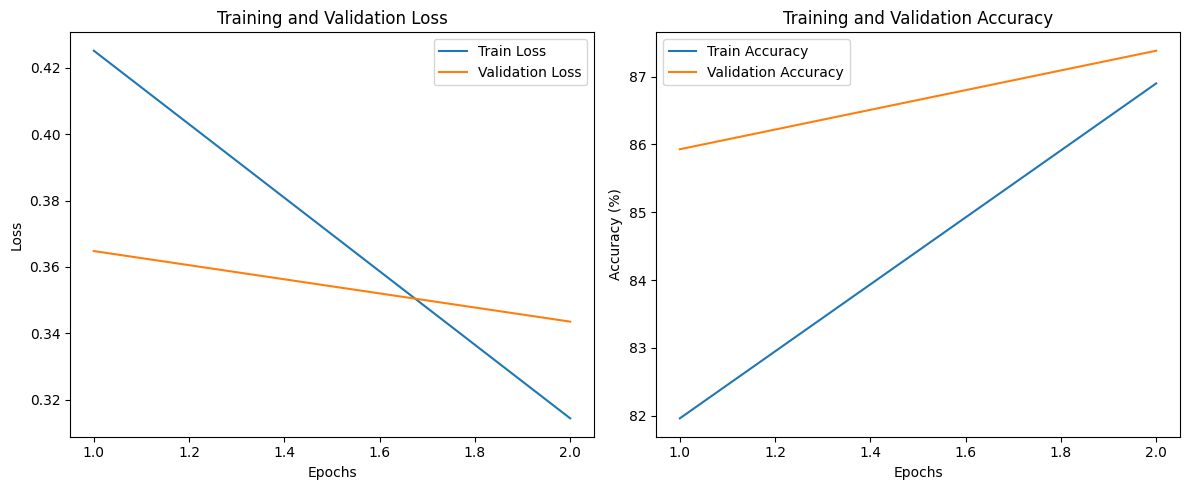

XLM-RoBERTa Modeli için Eğitim Verisi Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.99      0.94     19204
           1       0.91      0.57      0.70      4596

    accuracy                           0.91     23800
   macro avg       0.91      0.78      0.82     23800
weighted avg       0.91      0.91      0.90     23800

XLM-RoBERTa Modeli için Test Verisi Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2804
           1       0.82      0.48      0.60       711

    accuracy                           0.87      3515
   macro avg       0.85      0.73      0.76      3515
weighted avg       0.87      0.87      0.86      3515



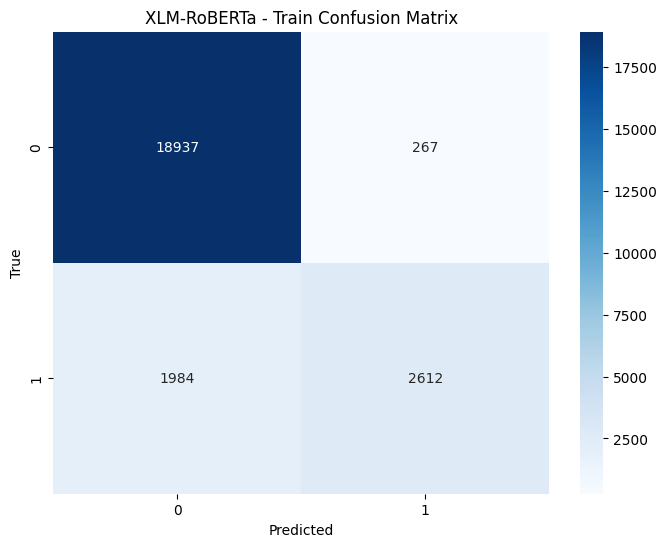

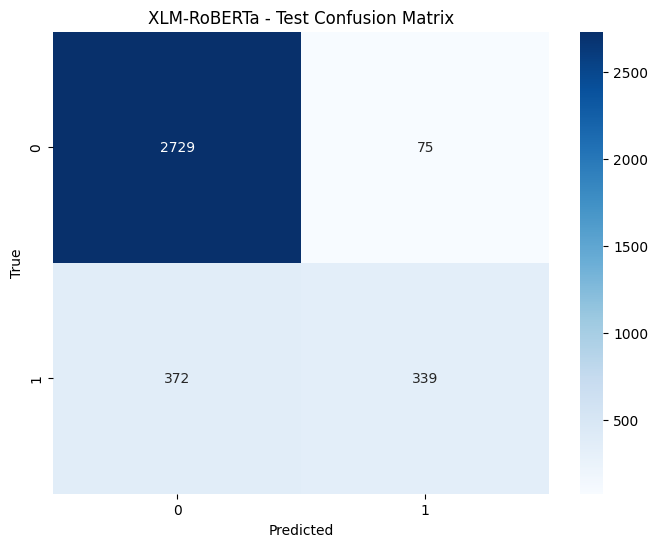

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# Confusion Matrix Fonksiyonu
def plot_confusion_matrix(y_true, y_pred, num_classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Sınıflandırma Raporları Fonksiyonu
def print_classification_results(model_name, train_labels, train_preds, test_labels, test_preds):
    print(f"{model_name} Modeli için Eğitim Verisi Sınıflandırma Raporu:")
    print(classification_report(train_labels, train_preds))
    print(f"{model_name} Modeli için Test Verisi Sınıflandırma Raporu:")
    print(classification_report(test_labels, test_preds))

# GPU kullanımı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Veri Yükleme
train_data_path = "/content/drive/My Drive/zemberturk_embeddings.csv"
test_data_path = "/content/drive/My Drive/zemberturk_embeddings_test.csv"
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# XLM-RoBERTa Tokenizer ve Modeli
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Özel kelimeler listesi
custom_words = ["şerefsiz", "aptal", "salak", "kötü", "çirkin", "nefret",
                "gerizekalı", "haksız", "manyak", "amk", "aq", "iğrenç"]
tokenizer.add_tokens(custom_words)

# XLM-RoBERTa Modeli
xlm_roberta_model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(train_df['Offensive_Label'].unique())
)

# Modelin embedding katmanını yeniden boyutlandır
xlm_roberta_model.resize_token_embeddings(len(tokenizer))
xlm_roberta_model.to(device)

# Metin ve Etiketlerin Hazırlanması
train_texts = train_df['text'].values
train_labels = train_df['Offensive_Label'].values
test_texts = test_df['text'].values
test_labels = test_df['Offensive_Label'].values

# Eğitim ve doğrulama setini ayırırken %15 doğrulama seti almak için `train_test_split` fonksiyonunu doğru kullan
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)

# Dataset ve DataLoader'lar
class XLMRobertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = XLMRobertaDataset(train_texts, train_labels, tokenizer)
val_dataset = XLMRobertaDataset(val_texts, val_labels, tokenizer)
test_dataset = XLMRobertaDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# XLM-RoBERTa Eğitim Fonksiyonu
def train_xlm_roberta(model, train_loader, val_loader, optimizer, scheduler, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                _, predicted = torch.max(outputs.logits, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Hesaplamalar
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        # Listelere ekleme
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_accuracy:.2f}%")
        print("-" * 50)

        # Learning Rate Scheduler'ı her epoch sonunda uygula
        scheduler.step()

    # Loss ve Accuracy grafikleri
    plt.figure(figsize=(12, 5))

    # Loss Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# DistilBERT Değerlendirme Fonksiyonu
def evaluate_xlm_roberta(model, loader):
    model.eval()  # Modeli değerlendirme moduna al
    all_preds = []  # Tüm tahminler
    all_labels = []  # Tüm etiketler
    with torch.no_grad():  # Değerlendirme sırasında gradyan hesaplamamıza gerek yok
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Modelin çıktısını al
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Softmax fonksiyonunu kullanarak tahminleri alıyoruz
            preds = torch.argmax(F.softmax(outputs.logits, dim=1), dim=1).cpu().numpy()

            all_preds.extend(preds)  # Tahminleri listeye ekle
            all_labels.extend(labels.cpu().numpy())  # Gerçek etiketleri listeye ekle

    return all_labels, all_preds  # Gerçek etiketler ve tahminler döndürülür

# Model Parametreleri ve Eğitim
optimizer = torch.optim.AdamW(xlm_roberta_model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)  # Learning rate scheduler
epochs = 2  # Epoch sayısını artırdık

print("\nXLM-RoBERTa Modeli Eğitimde...")
xlm_roberta_model = train_xlm_roberta(xlm_roberta_model, train_loader, val_loader, optimizer, scheduler, epochs)

# Performans Değerlendirmesi
train_labels, train_preds = evaluate_xlm_roberta(xlm_roberta_model, train_loader)
test_labels, test_preds = evaluate_xlm_roberta(xlm_roberta_model, test_loader)

# Sonuçları Yazdır
print_classification_results("XLM-RoBERTa", train_labels, train_preds, test_labels, test_preds)
plot_confusion_matrix(train_labels, train_preds, len(train_df['Offensive_Label'].unique()), 'XLM-RoBERTa - Train Confusion Matrix')
plot_confusion_matrix(test_labels, test_preds, len(train_df['Offensive_Label'].unique()), 'XLM-RoBERTa - Test Confusion Matrix')
